In [5]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from IPython.display import clear_output
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, RandomAutocontrast, Resize, PILToTensor
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
import random
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import csv


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

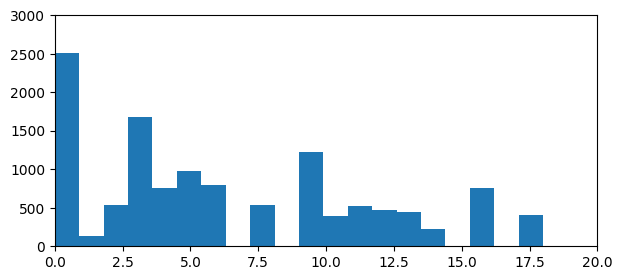

In [3]:
train_ans = pd.read_csv('human_poses_data/train_answers.csv')

plt.figure(figsize=(7, 3))
plt.axis((0, 20, 0, 3000))
# plt.xticks(np.arange(0, 20, 1.0))
plt.hist(train_ans['target_feature'].values, bins=20)
plt.show()

In [6]:
targets = list(train_ans['target_feature'].values)

index_to_target = []
for target in sorted(set(targets)):
    print(f'{target} - {targets.count(target)}')
    index_to_target.append(target)

index_to_target = np.array(index_to_target)

print()
print(index_to_target)

0 - 2512
1 - 135
2 - 530
3 - 1680
4 - 752
5 - 982
6 - 800
8 - 533
9 - 1223
10 - 390
11 - 528
12 - 469
13 - 442
14 - 228
16 - 753
18 - 410

[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 16 18]


In [8]:
class Data():
    def __init__(self, image_dir, train, transform):
        """
        image_dir: путь к папке с изображениями
        transform: torchvision трансформации
        """
        self.image_dir = image_dir
        self.transform = transform
        self.train = train
        self.le = LabelEncoder()

        # Список всех файлов с нужными расширениями
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ]

        if self.train:
            train_ans = pd.read_csv('human_poses_data/train_answers.csv')
            label_map = dict(zip(train_ans['img_id'].values, train_ans['target_feature'].values))
            self.label_map = label_map

            # Преобразуем метки в плотный диапазон 0-15
            original_labels = list(label_map.values())
            encoded_labels = self.le.fit_transform(original_labels)
            self.label_map = dict(zip(label_map.keys(), encoded_labels))
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Загружаем изображение
        image = Image.open(img_path)
        image = self.transform(image)
            
        # Определяем метку по имени файла
        if self.train:
            label = self.label_map[int(img_name.split('.')[0])]
            return image, label
        else:
            return image

In [31]:
transform = Compose([
    Resize((128, 128)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
    # RandomAutocontrast(p=1.0),
])

train_data = Data(image_dir="human_poses_data/img_train",
                 train=True,
                 transform=transform)

test_set = Data(image_dir="human_poses_data/img_test",
                 train=False,
                 transform=transform)

train_set, valid_set = random_split(train_data, (0.8, 0.2))


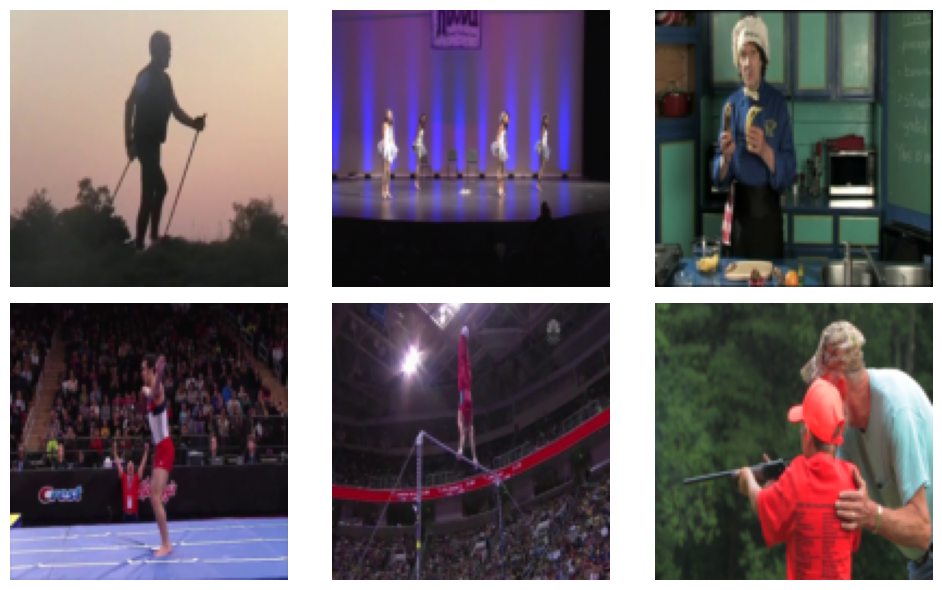

In [32]:
def show_dataset_images(dataset, num_images=6, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images):
        image, _ = dataset[i]
        
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = image * 0.25 + 0.5
        image = np.clip(image, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_images(train_set, num_images=6)


In [33]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset, target_size=1000):
        self.original_dataset = original_dataset
        self.target_size = target_size
        self.class_indices = defaultdict(list)
        
        for i in range(len(original_dataset)):
            _, label = original_dataset[i]
            self.class_indices[label].append(i)
        
        self.samples = []
        
        for _, indices in self.class_indices.items():
            current_count = len(indices)
            
            if current_count == 0:
                continue
                
            elif current_count < target_size:
                needed = target_size - current_count
                
                self.samples.extend([(idx, False) for idx in indices])
                
                aug_source_indices = np.random.choice(indices, size=needed, replace=True)
                self.samples.extend([(idx, True) for idx in aug_source_indices])
                
            elif current_count > target_size:
                selected_indices = random.sample(indices, target_size)
                self.samples.extend([(idx, False) for idx in selected_indices])
                
        self.aug_transform = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=10),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        ])
        
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        original_idx, should_augment = self.samples[idx]
        image, label = self.original_dataset[original_idx]
        
        if should_augment:
            image = self.aug_transform(image)
            
        return image, label

balanced_train_set = BalancedDataset(train_set, 2000)


In [34]:
BATCH_SIZE = 128

train_loader = DataLoader(balanced_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # (16, 128, 128)
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (16, 64, 64)
        )


        # --------------skip1--------------
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 32, 32)

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(), # (32, 32, 32)
        )
        # --------------skip1--------------


        # --------------skip2--------------
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 16, 16)
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2), # (128, 8, 8)
        )
        # --------------skip2--------------


        # --------------skip3--------------
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 8, 8)
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (256, 2, 2)
        )
        # --------------skip3--------------




        self.skip1 = nn.Sequential(  # (16, 64, 64)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(),  # (32, 32, 32)
        )

        self.skip2 = nn.Sequential(  # (32, 32, 32)
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 8, 8)
        )
        
        self.skip3 = nn.Sequential(  # (128, 8, 8)
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (256, 4, 4) 
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 2, 2)
        )



        self.classifier = nn.Sequential(
            nn.Linear(256 * 2 * 2, 512),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 16)
        )

    def forward(self, x):
        x = self.block1(x)
        skip = self.skip1(x)
        out = self.block2(x)

        x = skip + out
        out = self.block3(x)
        skip = self.skip2(x)

        x = skip + out
        out = self.block4(x)
        skip = self.skip3(x)

        x = skip + out
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [36]:
model = Model4().to(device)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
       BatchNorm2d-2         [-1, 16, 128, 128]              32
             PReLU-3         [-1, 16, 128, 128]               1
         MaxPool2d-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
             PReLU-7           [-1, 32, 32, 32]               1
            Conv2d-8           [-1, 32, 64, 64]           4,640
       BatchNorm2d-9           [-1, 32, 64, 64]              64
            PReLU-10           [-1, 32, 64, 64]               1
        MaxPool2d-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,248
      BatchNorm2d-13           [-1, 32, 32, 32]              64
            PReLU-14           [-1, 32,

In [37]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.figure(figsize=(12,4))
    
    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b", label=f'Train Loss = {train[-1]}')
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange", label=f'Val Loss = {val[-1]}')
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="orange", label=f'Acuracy = {acc[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="orange", label=f'F1 = {f1[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

In [38]:
def run_epoch(model, dataloader, loss_function, optimizer=None):
    
    model.train() if optimizer is not None else model.eval()

    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)

            total_loss += loss.item()

            if optimizer != None:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            else:
                all_preds.extend(pred.argmax(dim=1).cpu().numpy())
                all_targets.extend(y.cpu().numpy())

            
    avg_loss = total_loss / len(dataloader)
    
    if optimizer is None:
        acc = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='macro')
        return avg_loss, acc, f1
    else:
        return avg_loss, None, None


In [ ]:
NUM_EPOCHS = 30

#  Обучение модели
model = Model4().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-4)


train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for i in range(NUM_EPOCHS):

    train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    accuracy.append(acc)
    f1.append(f1_)

    if f1[-1] == max(f1):
        torch.save(model, 'model4_16_best_model.pth')
        torch.save(model.state_dict(), 'model4_16_best_weights.pth')

    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)



print(f"Min loss: {min(test_loss_hist)}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

  0%|          | 0/250 [00:00<?, ?it/s]

 63%|██████▎   | 158/250 [06:25<03:34,  2.33s/it]

In [29]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

In [ ]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

In [31]:
# import torch
# torch.cuda.empty_cache()  

In [ ]:
class Model5(nn.Module):
    def __init__(self):
        super(Model5, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),  # (8, 256, 256)
            nn.BatchNorm2d(8),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (8, 128, 128)
            
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  # (16, 128, 128)
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (16, 64, 64)
        )


        # --------------skip1--------------
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 32, 32)

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(), # (32, 32, 32)
        )
        # --------------skip1--------------


        # --------------skip2--------------
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 16, 16)
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2), # (128, 8, 8)
        )
        # --------------skip2--------------


        # --------------skip3--------------
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 8, 8)
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (256, 2, 2)
        )
        # --------------skip3--------------




        self.skip1 = nn.Sequential(  # (16, 64, 64)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(),  # (32, 32, 32)
        )

        self.skip2 = nn.Sequential(  # (32, 32, 32)
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 8, 8)
        )
        
        self.skip3 = nn.Sequential(  # (128, 8, 8)
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (256, 4, 4) 
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 2, 2)
        )



        self.classifier = nn.Sequential(
            nn.Linear(256 * 2 * 2, 512),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 16)
        )

    def forward(self, x):
        x = self.block1(x)
        skip = self.skip1(x)
        out = self.block2(x)

        x = skip + out
        out = self.block3(x)
        skip = self.skip2(x)

        x = skip + out
        out = self.block4(x)
        skip = self.skip3(x)

        x = skip + out
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [33]:
model = Model5().to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
       BatchNorm2d-2          [-1, 8, 256, 256]              16
             PReLU-3          [-1, 8, 256, 256]               1
         MaxPool2d-4          [-1, 8, 128, 128]               0
            Conv2d-5         [-1, 16, 128, 128]           1,168
       BatchNorm2d-6         [-1, 16, 128, 128]              32
             PReLU-7         [-1, 16, 128, 128]               1
         MaxPool2d-8           [-1, 16, 64, 64]               0
            Conv2d-9           [-1, 32, 32, 32]           4,640
      BatchNorm2d-10           [-1, 32, 32, 32]              64
            PReLU-11           [-1, 32, 32, 32]               1
           Conv2d-12           [-1, 32, 64, 64]           4,640
      BatchNorm2d-13           [-1, 32, 64, 64]              64
            PReLU-14           [-1, 32,

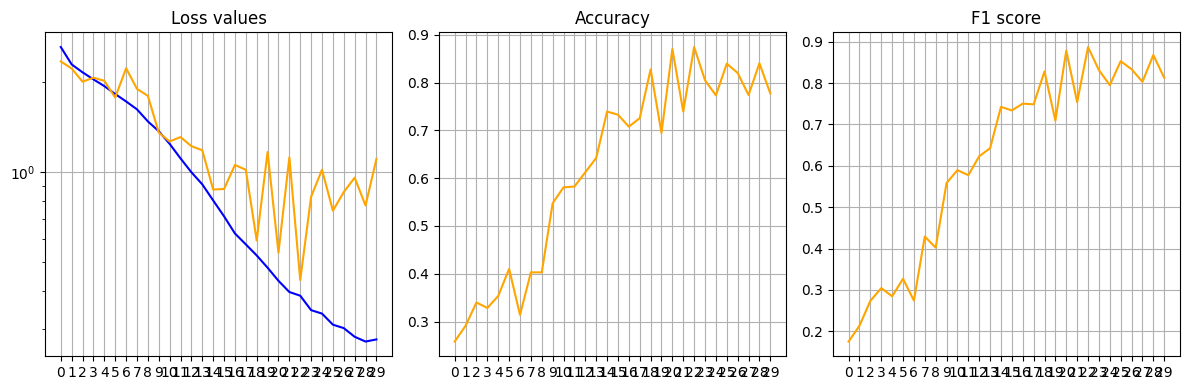

Min loss: 0.43592733442783355
Max Accuracy: 0.8745954692556634
Max F1: 0.886959397157814


In [ ]:
# NUM_EPOCHS = 30

# #  Обучение модели
# model = Model5().to(device)

# loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), 
#                            lr=0.001,
#                            weight_decay=1e-4
#                            )


# train_loss_hist = []
# test_loss_hist = []
# accuracy = []
# f1 = []

# for i in range(NUM_EPOCHS):

#     train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
#     train_loss_hist.append(train_loss)

#     test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
#     test_loss_hist.append(test_loss)

#     accuracy.append(acc)
#     f1.append(f1_)

#     if f1[-1] == max(f1):
#         torch.save(model, 'model5_best_model.pth')
#         torch.save(model.state_dict(), 'model5_best_weights.pth')

#     show_losses(train_loss_hist, test_loss_hist, accuracy, f1)



# print(f"Min loss: {min(test_loss_hist)}")
# print(f"Max Accuracy: {max(accuracy)}")
# print(f"Max F1: {max(f1)}")

In [ ]:
# from sklearn.metrics import classification_report

# y_true, y_pred = predict(model, valid_loader)

# print(classification_report(y_true, y_pred))

100%|██████████| 10/10 [00:23<00:00,  2.36s/it]

              precision    recall  f1-score   support

           0       0.96      0.54      0.69       256
           1       0.94      1.00      0.97        16
           2       0.86      0.88      0.87        43
           3       1.00      0.40      0.57       166
           4       0.49      1.00      0.66        66
           5       0.79      0.91      0.84       107
           6       0.90      0.96      0.93        93
           8       0.83      0.96      0.89        56
           9       0.94      0.84      0.89       131
          10       1.00      0.94      0.97        50
          11       0.69      0.98      0.81        53
          12       0.78      1.00      0.88        49
          13       0.50      0.88      0.64        34
          14       0.77      1.00      0.87        20
          16       0.49      0.98      0.66        63
          18       0.93      0.82      0.87        33

    accuracy                           0.78      1236
   macro avg       0.80   

In [ ]:
# model = torch.load('model5_best_model.pth', weights_only=False)

In [40]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

100%|██████████| 10/10 [00:25<00:00,  2.54s/it]

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       256
           1       1.00      1.00      1.00        16
           2       0.96      0.58      0.72        43
           3       0.76      0.81      0.78       166
           4       0.86      0.98      0.92        66
           5       0.94      0.79      0.86       107
           6       0.91      0.97      0.94        93
           8       0.98      0.88      0.92        56
           9       0.91      0.87      0.89       131
          10       0.94      0.96      0.95        50
          11       0.95      1.00      0.97        53
          12       0.94      0.94      0.94        49
          13       0.67      0.94      0.78        34
          14       0.67      1.00      0.80        20
          16       0.88      0.95      0.92        63
          18       0.91      0.97      0.94        33

    accuracy                           0.87      1236
   macro avg       0.88   

In [ ]:
model.eval()
test_preds = []
test_ids = []

with torch.no_grad():
    for img_name in tqdm(test_set.image_files):
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image)
        
        output = model(image.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
        
        test_ids.append(img_name.split('.')[0])
        test_preds.append(pred.item())

test_ids, test_preds = zip(*sorted(zip(test_ids, test_preds), key=lambda x: int(x[0])))

with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target_feature'])
    writer.writerows(zip(test_ids, index_to_target[test_preds].tolist()))


100%|██████████| 5301/5301 [02:15<00:00, 39.09it/s]


In [ ]:
model.eval()
test_preds = []
test_ids = []

with torch.no_grad():
    images = test_set.image_files
    for i, img_name in tqdm(enumerate(images, start=1)):  # start=1 для нумерации с 1
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image)
        
        output = model(image.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
        
        test_ids.append(i)  # Используем порядковый номер
        test_preds.append(pred.item())

# Сортировка не нужна, так как мы уже обрабатывали файлы по порядку
# test_ids, test_preds = zip(*sorted(zip(test_ids, test_preds), key=lambda x: int(x[0])))

with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target_feature'])
    writer.writerows(zip(test_ids, test_preds))

5301it [01:47, 49.41it/s]
